In [97]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Concatenate, Dense, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
from scipy.stats import norm
import tensorflow_probability

In [98]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

rng = np.random.RandomState(120)  # For reproducibility of results

# ============================
# Specifying Hyper-parameters:
# ============================


# Ip:0.01
# Bt: 0.001
# triang: 0.01
# Rmag: 0.02
# Rmin: 0.03
# kappa: 0.01
# beta_N: 0.2
# ne_ped: 3.0e18
# sigma_x1 = 0.01  # Tune how far from original data points is sampled (x1 dimension)
# sigma_x2 = 0.001  # Tune how far from original data points is sampled (x2 dimension)
# sigma_x3 = 0.01 
# sigma_x4 = 0.02
# sigma_x5 = 0.03
# sigma_x6 = 0.01 #RESCALE
# sigma_x7 = 0.2 
# sigma_x8 = 0.3 
# sigma_y = 0.08  # Tune how far from target variables is sampled (y dimension)
# sigma_y2=0.02
#(plasma.Te_ped_EPED-plasma.Te_ped_exp).abs().mean()


In [99]:
num_epochs = 8000  # Setting the number of training epochs
batch_size = 54 # Setting the size of training batches
num_select = 100  # Amount of data points available
mean_prior_weight =0.01
noise_prior_weight = 20
nll_weight=1
nll_weight2=5
p_error=0.2
# Setting the expected aleatoric noise per dimension [2, 10, 1] shape !!! NOT GENERALIZED !!!
# exp_noise_1 = 0.05#0.2*Te_ped_EPED changed on step_fn
# exp_noise_2 = 0.01

# exp_noise_vec1 = np.tile([exp_noise_1], (batch_size, 1))
# exp_noise_vec1 = tf.constant(exp_noise_vec1, dtype=tf.float32)
# exp_noise_vec2 = np.tile([exp_noise_2], (batch_size, 1))
# exp_noise_vec2 = tf.constant(exp_noise_vec2, dtype=tf.float32)
# exp_noise_temp = np.tile([exp_noise_x1], (batch_size, 1)), np.tile([exp_noise_x2], (batch_size, 1)),np.tile([exp_noise_x3], (batch_size, 1)), np.tile([exp_noise_x4], (batch_size, 1)),np.tile([exp_noise_x5], (batch_size, 1)), np.tile([exp_noise_x6], (batch_size, 1)),np.tile([exp_noise_x7], (batch_size, 1)),np.tile([exp_noise_x8], (batch_size, 1))
# exp_noise_std = tf.constant(exp_noise_temp, dtype=tf.float32)

initial_lr = 0.001  # Setting the learning rate for the optimizer
decay_rate = 0.5  # Decay of the learning rate scheduler

In [100]:
# plasma.loc[:,['Ip[MA]', 'Bt[T]', 'Triang.', 'Rmag[M]', 'rminor[m]',
        # 'kappa', 'beta_n_exp', 'ne_ped_exp','Te_ped_EPED','Delta_EPED','Sigma_Te_ped','Sigma_Delta']]

In [101]:

plasma0=pd.read_csv('../data/europed_predictions_more_input.csv')
plasma0=plasma0[plasma0['Ip[MA]']!=0]
plasma0['epsilon']=plasma0['rminor[m]']/plasma0['Rmag[M]']
def myscaler(data):
        std=data.std()
        mean=data.mean()
        return (data-mean)/std,mean,std
plasma=myscaler(plasma0)[0]
sigmay2=(plasma0.Delta_EPED-plasma0.Delta_exp).abs()/myscaler(plasma0.Delta_EPED)[2]
sigmay2[sigmay2==0]=0.00001
plasma['Sigma_Te_ped']=(plasma0.Te_ped_EPED-plasma0.Te_ped_exp).abs()/myscaler(plasma0.Te_ped_EPED)[2]
plasma['Sigma_Delta']=sigmay2
selected_dataset=plasma0.loc[:,['Ip[MA]', 'Bt[T]', 'Triang.', 'epsilon',
    'kappa', 'beta_n_exp', 'ne_ped_exp','Te_ped_EPED','Delta_EPED','Sigma_Te_ped','Sigma_Delta']]

train,test=train_test_split(plasma.loc[:,['Ip[MA]', 'Bt[T]', 'Triang.', 'epsilon',
    'kappa', 'beta_n_exp', 'ne_ped_exp','Te_ped_EPED','Delta_EPED','Sigma_Te_ped','Sigma_Delta']],test_size=0.098,shuffle=False,random_state=2)
sigma_x1 = 0.01/myscaler(selected_dataset)[2][0]
sigma_x2 = 0.001/myscaler(selected_dataset)[2][1]  
sigma_x3 = 0.01 /myscaler(selected_dataset)[2][2]
sigma_x4 = 0.01/myscaler(selected_dataset)[2][3]
# sigma_x5 = 0.03/myscaler(selected_dataset)[2][4]
sigma_x6 = 0.01/myscaler(selected_dataset)[2][4]
sigma_x7 = 0.2/myscaler(selected_dataset)[2][5]
sigma_x8 = 0.3/myscaler(selected_dataset)[2][6]

x1_train=tf.constant(train.loc[:,'Ip[MA]'].values, dtype=tf.float32)
x2_train=tf.constant(train.loc[:,'Bt[T]'].values, dtype=tf.float32)
x3_train=tf.constant(train.loc[:,'Triang.'].values, dtype=tf.float32)
x4_train=tf.constant(train.loc[:,'epsilon'].values, dtype=tf.float32)
# x5_train=tf.constant(train.loc[:,'rminor[m]'].values, dtype=tf.float32)
x6_train=tf.constant(train.loc[:,'kappa'].values, dtype=tf.float32)
x7_train=tf.constant(train.loc[:,'beta_n_exp'].values, dtype=tf.float32)
x8_train=tf.constant(train.loc[:,'ne_ped_exp'].values, dtype=tf.float32)
y_train=tf.constant(train.loc[:,'Te_ped_EPED'].values, dtype=tf.float32)
y2_train=tf.constant(train.loc[:,'Delta_EPED'].values, dtype=tf.float32)
sigma_y_train=tf.constant(train.loc[:,'Sigma_Te_ped'].values, dtype=tf.float32)
sigma_y2_train=tf.constant(train.loc[:,'Sigma_Delta'].values, dtype=tf.float32)
Train=train
Train.shape

C:\Users\paner\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(864, 11)

0.30560068083446734

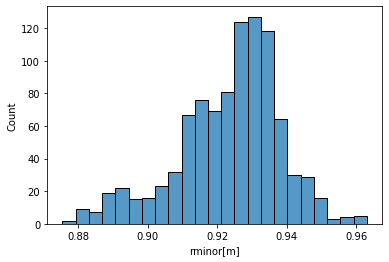

In [102]:
sns.histplot(plasma0['rminor[m]'])
plasma0['epsilon'].mean()

In [103]:
def noise(x1, x2,x3,x4,x6,x7,x8, slope, rng=np.random):
    noise_std = np.maximum(0.0, x1+x2+x3+x4+x5+x6+x7+x8) * slope
    return rng.normal(0, noise_std).astype(np.float32)
# =========================
# Creating model structure:
# =========================

def mean_dist_fn(variational_layer):
    def mean_dist(inputs):
        bias_mean = variational_layer.bias_posterior.mean()

        kernel_mean = variational_layer.kernel_posterior.mean()
        kernel_std = variational_layer.kernel_posterior.stddev()
        

        mu_mean = tf.matmul(inputs, kernel_mean) + bias_mean
        mu_var = tf.matmul(inputs ** 2, kernel_std ** 2)
        mu_std = tf.sqrt(mu_var)
        return tfd.Normal(mu_mean, mu_std)
        

    return mean_dist

def create_model(n_hidden1=15,n_hidden2=7):
    leaky_relu = LeakyReLU(alpha=0.2)
    variational_layer = tfpl.DenseReparameterization(1, name='mu')
    variational_layer2 = tfpl.DenseReparameterization(1, name='mu2')
    
    input_x1 = Input(shape=(1,))  
    input_x2 = Input(shape=(1,))  
    input_x3 = Input(shape=(1,))
    input_x4 = Input(shape=(1,))
    # input_x5 = Input(shape=(1,))
    input_x6 = Input(shape=(1,))
    input_x7 = Input(shape=(1,))
    input_x8 = Input(shape=(1,))
    input_combined = Concatenate(axis=1)([input_x1,input_x2,
        input_x3,input_x4,input_x6,input_x7,input_x8])
    d_combined = Dense(n_hidden1, input_dim=7, activation=leaky_relu)(input_combined)
    d_combined = Dense(n_hidden2, activation=leaky_relu)(d_combined)
    s1 = Dense(1, activation='softplus', name='sigma1')(d_combined)
    s2 = Dense(1, activation='softplus', name='sigma2')(d_combined)
    m = variational_layer(d_combined)
    m2=variational_layer2(d_combined)
    

    mean_dist = Lambda(mean_dist_fn(variational_layer))(d_combined)
    mean_dist2 = Lambda(mean_dist_fn(variational_layer2))(d_combined)
    ndim_out = Lambda(lambda p: tfd.Normal(p[0],p[1]))((m,s1))
    ndim_out2=Lambda(lambda p: tfd.Normal(p[0],p[1]))((m2,s2))
    return Model([input_x1,input_x2,
        input_x3,input_x4,input_x6,input_x7,input_x8], [ndim_out, mean_dist,ndim_out2,mean_dist2])


model = create_model()

# =======================================
# Creating model training infrastructure:
# =======================================
def lr_scheduler(decay_steps):
    return tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate)


def optimizer_function(lr):
    return tf.keras.optimizers.Adam(learning_rate=lr)


def data_loader(x1, x2,x3,x4,x6,x7,x8, y,y2,sigma_y,sigma_y2, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x1, x2,x3,x4,x6,x7,x8, y,y2,sigma_y,sigma_y2))
    ds = ds.shuffle(x1.shape[0])
    return ds.batch(batch_size)


# def data_loader2(x, y, batch_size):
#     ds = tf.data.Dataset.from_tensor_slices((x, y))
#     ds = ds.shuffle(x.shape[0])
#     return ds.batch(batch_size)

def backprop(model, loss, tape):
    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    return zip(gradients, trainable_vars)

C:\Users\paner\Anaconda3\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [104]:
# The function below uses a lot of manually shaped tensors, so careful generalization is needed
@tf.function
def NCP_train_step(model, optimizer, x1, x2,x3,x4,x6,x7,x8, y,y2,sigma_y,sigma_y2):
    # Format input data
    y_reshape = tf.reshape(y, [batch_size, 1])  # MANUAL RESHAPING
    y_nll = [y_reshape]  # MANUAL RESHAPING
    y2_reshape = tf.reshape(y2, [batch_size, 1])  # MANUAL RESHAPING
    y2_nll = [y2_reshape] 
    sigma_y_reshape = tf.reshape(sigma_y, [batch_size, 1])
    sigma_y2_reshape = tf.reshape(sigma_y2, [batch_size, 1])
    
    # Generate random OOD data from training data
    ood_x1 = x1 + tf.random.normal(tf.shape(x1), stddev=sigma_x1)
    ood_x2 = x2 + tf.random.normal(tf.shape(x2), stddev=sigma_x2)
    ood_x3 = x3 + tf.random.normal(tf.shape(x3), stddev=sigma_x3)
    ood_x4 = x4 + tf.random.normal(tf.shape(x4), stddev=sigma_x4)
    # ood_x5 = x5 + tf.random.normal(tf.shape(x5), stddev=sigma_x5)
    ood_x6 = x6 + tf.random.normal(tf.shape(x6), stddev=sigma_x6)
    ood_x7 = x7 + tf.random.normal(tf.shape(x7), stddev=sigma_x7)
    ood_x8 = x8 + tf.random.normal(tf.shape(x8), stddev=sigma_x8)

    # NCP output prior
    ood_mean_prior = tfd.Normal(y_reshape, sigma_y_reshape)
    ood_mean_prior2 = tfd.Normal(y2_reshape, sigma_y2_reshape)

    with tf.GradientTape() as tape:
        # For train data inputs
        ndim_dist, mean_dist,ndim_dist2, mean_dist2 = model([x1, x2,x3,x4,x6,x7,x8], training=True)

        # For OOD data inputs
        ood_ndim_dist, ood_mean_dist,ood_ndim_dist2, ood_mean_dist2 = model([ood_x1, ood_x2,ood_x3,ood_x4,ood_x6,ood_x7,ood_x8], training=True)

        # A single combined Negative Log-Likelihood for all dimensions
        nll = -ndim_dist.log_prob(y_nll)
        nll_reshape = tf.reshape(nll, [1, batch_size, 1])  # MANUAL RESHAPING
        nll2 = -ndim_dist2.log_prob(y2_nll)
        nll2_reshape = tf.reshape(nll2, [1, batch_size, 1])  # MANUAL RESHAPING

        # KL divergence between output prior and OOD mean distribution
        kl_ood_mean = tfd.kl_divergence(ood_mean_prior, ood_mean_dist)#epistemic
        kl_ood_mean_reshape = tf.reshape(kl_ood_mean, [1, batch_size, 1])  # MANUAL RESHAPING
        kl_ood_mean2 = tfd.kl_divergence(ood_mean_prior2, ood_mean_dist2)#epistemic
        kl_ood_mean_reshape2 = tf.reshape(kl_ood_mean2, [1, batch_size, 1])

        # Encouraging aleatoric uncertainty to be a set amount for OOD data
        y_reshape_0=y_reshape*myscaler(plasma0.Te_ped_EPED)[2]+myscaler(plasma0.Te_ped_EPED)[1]
        y2_reshape_0=y2_reshape*myscaler(plasma0.Delta_EPED)[2]+myscaler(plasma0.Delta_EPED)[1]
        exp_noise_vec1 = p_error*y_reshape_0/myscaler(plasma0.Te_ped_EPED)[2]
        exp_noise_vec2 = 0.5*p_error*y2_reshape_0/myscaler(plasma0.Delta_EPED)[2]
        # exp_noise_vec1 = tf.constant(exp_noise_vec1, dtype=tf.float32)
        exp_noise_dist = tfd.Normal(0, exp_noise_vec1)#aleatoric
        mean_noise_dist = tfd.Normal(0, ood_ndim_dist.stddev())#what increases output error or input error
        exp_noise_dist2 = tfd.Normal(0, exp_noise_vec2)
        mean_noise_dist2 = tfd.Normal(0, ood_ndim_dist2.stddev())
        # KL-Divergence between the noise distributions to fit towards the prior:
        kl_ood_noise = tfd.kl_divergence(exp_noise_dist, mean_noise_dist)#aleatoric
        kl_ood_noise_reshape = tf.reshape(kl_ood_noise, [1, batch_size, 1])  # MANUAL RESHAPING
        kl_ood_noise2 = tfd.kl_divergence(exp_noise_dist2, mean_noise_dist2)#aleatoric
        kl_ood_noise_reshape2 = tf.reshape(kl_ood_noise2, [1, batch_size, 1])

        # Calculate the combined loss term
        loss = tf.reduce_sum(
            nll_weight*(nll_reshape) +nll_weight2*(nll2_reshape)+ mean_prior_weight * (kl_ood_mean_reshape+kl_ood_mean_reshape2) + noise_prior_weight * (kl_ood_noise_reshape+kl_ood_noise_reshape2))
        nll=tf.reduce_sum(nll_reshape)
        nll2=tf.reduce_sum(nll2_reshape)
        epistemic_loss=tf.reduce_sum(kl_ood_mean_reshape+kl_ood_mean_reshape2)
        aleatoric_loss=tf.reduce_sum(kl_ood_noise_reshape+kl_ood_noise_reshape2)

    optimizer.apply_gradients(backprop(model, loss, tape))
    return loss, mean_dist.mean(), mean_dist2.mean(),epistemic_loss, aleatoric_loss, nll,nll2

def train(model, x1, x2,x3,x4,x6,x7,x8, y,y2,sigma_y,sigma_y2, batch_size, epochs, step_fn):
    steps_per_epoch = int(np.ceil(y.shape[0] / batch_size))
    steps = epochs * steps_per_epoch

    scheduler = lr_scheduler(steps)
    optimizer = optimizer_function(scheduler)
    loader = data_loader(x1, x2,x3,x4,x6,x7,x8, y,y2,sigma_y,sigma_y2, batch_size=batch_size)

    loss_tracker = tf.keras.metrics.Mean(name='loss')
    mse_tracker = tf.keras.metrics.MeanSquaredError(name='mse')
    mse_tracker2 = tf.keras.metrics.MeanSquaredError(name='mse2')

    loss_list = []
    mse_list = []
    mse2_list = []
    epi=[]
    alea=[]
    nll_list=[]
    nll2_list=[]

    for epoch in range(1, epochs + 1):
        for x1_batch, x2_batch,x3_batch,x4_batch,x6_batch,x7_batch,x8_batch, y_batch, y2_batch,sigma_y_batch,sigma_y2_batch in loader:
            loss, y_pred,y2_pred, epi_loss, alea_loss, nll,nll2 = step_fn(model, optimizer, x1_batch,x2_batch,x3_batch,x4_batch,x6_batch,x7_batch,x8_batch, y_batch,y2_batch,sigma_y_batch,sigma_y2_batch)

            loss_tracker.update_state(loss)
            mse_tracker.update_state(y_batch, y_pred)
            mse_tracker2.update_state(y2_batch, y2_pred)

        loss_list.append(loss_tracker.result().numpy())
        mse_list.append(mse_tracker.result().numpy())
        mse2_list.append(mse_tracker2.result().numpy())
        epi.append(epi_loss)
        alea.append(alea_loss)
        nll_list.append(nll)
        nll2_list.append(nll2)

        if 1 and epoch % 100 == 0:
            print(f'epoch {epoch}: loss = {loss_tracker.result():.3f}, mse = {mse_tracker.result():.3f}, mse2={mse_tracker2.result():.3f}, epi={epi_loss:.3f}, alea={alea_loss:.3f}, nll={nll:.3f},nll2={nll2:.3f}')
        loss_tracker.reset_states()
        mse_tracker.reset_states()
        mse_tracker2.reset_states()
    metric_tensor = [loss_list, mse_list,mse2_list,epi,alea,nll_list,nll2_list]
    return metric_tensor

In [105]:
history = train(model, x1_train, x2_train, x3_train,x4_train,x6_train,x7_train,x8_train, y_train,y2_train,sigma_y_train,sigma_y2_train, batch_size=batch_size, epochs=1000, step_fn=NCP_train_step)

epoch 100: loss = 472.670, mse = 0.301, mse2=0.206, epi=4806.296, alea=2.394, nll=55.425,nll2=62.089
epoch 200: loss = 430.584, mse = 0.137, mse2=0.158, epi=2918.883, alea=1.763, nll=43.423,nll2=60.645
epoch 300: loss = 404.997, mse = 0.084, mse2=0.124, epi=3705.643, alea=1.544, nll=33.752,nll2=67.103
epoch 400: loss = 395.736, mse = 0.064, mse2=0.111, epi=2808.583, alea=1.150, nll=39.152,nll2=58.384
epoch 500: loss = 407.329, mse = 0.057, mse2=0.098, epi=3430.545, alea=1.435, nll=37.873,nll2=62.961
epoch 600: loss = 402.985, mse = 0.053, mse2=0.092, epi=3385.475, alea=1.293, nll=25.885,nll2=56.487
epoch 700: loss = 400.226, mse = 0.050, mse2=0.089, epi=3657.961, alea=1.286, nll=28.516,nll2=64.095
epoch 800: loss = 397.624, mse = 0.048, mse2=0.088, epi=3142.489, alea=1.075, nll=27.060,nll2=55.370
epoch 900: loss = 402.852, mse = 0.047, mse2=0.088, epi=3303.963, alea=0.999, nll=31.000,nll2=62.694
epoch 1000: loss = 378.380, mse = 0.044, mse2=0.087, epi=2525.031, alea=1.217, nll=27.067,n

In [133]:
# model.save_weights('../weights/BNN_EPED_7D_19-05_15-7')

In [89]:
# model.save_weights('../weights/BNN_EPED_7D_14-05_15-7_1')

In [106]:
# model.load_weights('../weights/BNN_EPED_7D_14-05_15-7_1')

In [107]:
# model.save_weights('../weights/BNN_EPED_7D_14-05_15-7')

In [108]:
# model.save_weights('../weights/BNN_EPED_7D_22-03_try')

In [109]:
# model.load_weights('../weights/BNN_EPED_7D_22-03_try')

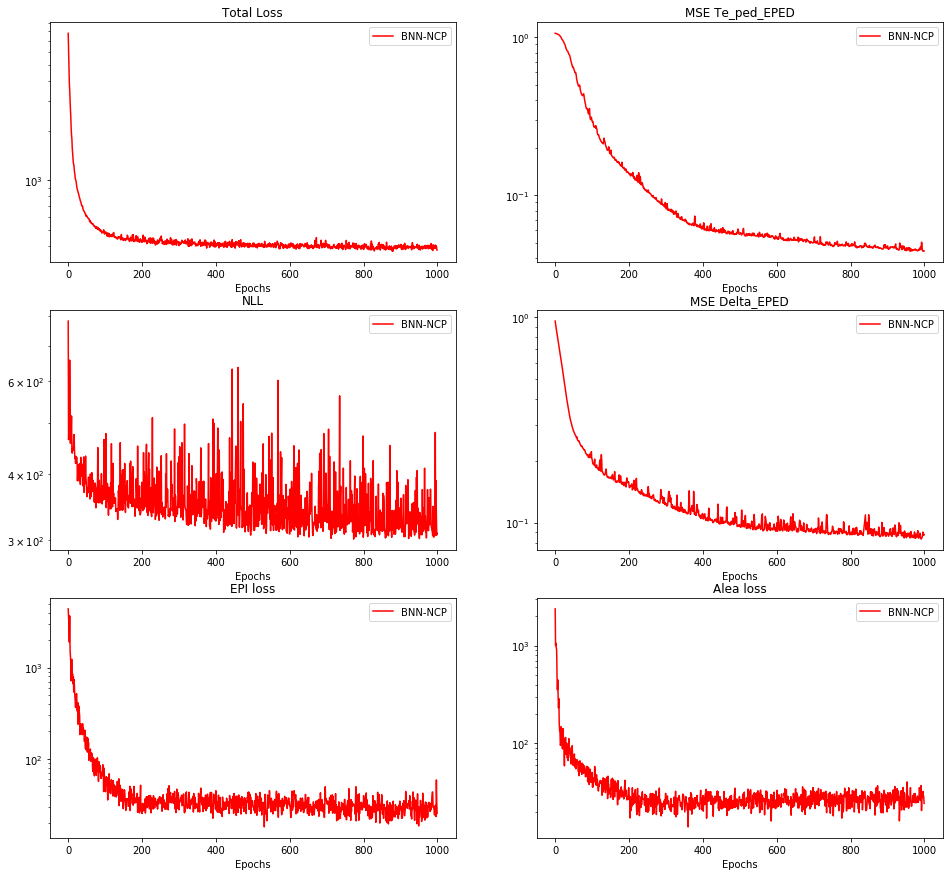

In [110]:
# Plotting training performance
fig = plt.figure(figsize=(16, 15))
ax = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6=fig.add_subplot(326)
ax.set_title("Total Loss")
ax.plot(history[0], color='red', label='BNN-NCP',scaley='log')
ax.set_yscale('log')
ax.set_xlabel('Epochs')
ax.legend()

ax2.set_title("MSE Te_ped_EPED")
ax2.plot(history[1], color='red', label='BNN-NCP')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.legend()

ax3.set_title("NLL")
ax3.plot(nll_weight*(np.array(history[5]))+nll_weight2*(np.array(history[6])), color='red', label='BNN-NCP')
ax3.set_yscale('log')
ax3.set_xlabel('Epochs')
ax3.legend()
ax4.set_title("MSE Delta_EPED")
ax4.plot(history[2], color='red', label='BNN-NCP')
ax4.set_yscale('log')
ax4.set_xlabel('Epochs')
ax4.legend()
ax5.set_title("EPI loss")
ax5.plot(mean_prior_weight*np.array(history[3]), color='red', label='BNN-NCP')
ax5.set_yscale('log')
ax5.set_xlabel('Epochs')
ax5.legend()

ax6.set_title("Alea loss")
ax6.plot(noise_prior_weight*np.array(history[4]), color='red', label='BNN-NCP')
ax6.set_yscale('log')
ax6.set_xlabel('Epochs')
ax6.legend()

plt.savefig('../figures/delete_later.png')

plt.show(block=False)

In [121]:
ndim_out_dist, mean_dist,ndim_out_dist2,mean_dist2=model([tf.constant(plasma['Ip[MA]'].values,dtype=tf.float32),tf.constant(plasma['Bt[T]'].values,dtype=tf.float32),
    tf.constant(plasma['Triang.'].values,dtype=tf.float32),tf.constant(plasma['epsilon'].values,dtype=tf.float32),
    tf.constant(plasma['kappa'].values,dtype=tf.float32),tf.constant(plasma['beta_n_exp'].values,dtype=tf.float32),
    tf.constant(plasma['ne_ped_exp'].values,dtype=tf.float32)])

In [122]:
# ndim_out_dist, mean_dist,ndim_out_dist2,mean_dist2=model([tf.constant(plasma['Ip[MA]'].values[0:2],dtype=tf.float32),tf.constant(plasma['Bt[T]'].values[0:2],dtype=tf.float32),
#     tf.constant(plasma['Triang.'].values[0:2],dtype=tf.float32),tf.constant(plasma['epsilon'].values[0:2],dtype=tf.float32),
#     tf.constant(plasma['kappa'].values[0:2],dtype=tf.float32),tf.constant(plasma['beta_n_exp'].values[0:2],dtype=tf.float32),
#     tf.constant(plasma['ne_ped_exp'].values[0:2],dtype=tf.float32)])
# print(ndim_out_dist.mean(),ndim_out_dist.stddev())
# print(mean_dist.mean(),mean_dist.stddev())

In [123]:
# ndim_out_dist, mean_dist,ndim_out_dist2,mean_dist2=model([tf.constant(plasma['Ip[MA]'].values[0:2],dtype=tf.float32),tf.constant(plasma['Bt[T]'].values[0:2],dtype=tf.float32),
#     tf.constant(plasma['Triang.'].values[0:2],dtype=tf.float32),tf.constant(plasma['epsilon'].values[0:2],dtype=tf.float32),
#     tf.constant(plasma['kappa'].values[0:2],dtype=tf.float32),tf.constant(plasma['beta_n_exp'].values[0:2],dtype=tf.float32),
#     tf.constant(plasma['ne_ped_exp'].values[0:2],dtype=tf.float32)])
# print(ndim_out_dist.mean(),ndim_out_dist.stddev())
# print(mean_dist.mean(),mean_dist.stddev())

In [124]:
def beta_fun(Te_ped=plasma0.Te_ped_EPED.values,ne_ped=plasma0.ne_ped_exp):
    mu0=4*np.pi*10**(-7)
    theta = np.linspace(0, 2*np.pi, 361).reshape(1,-1)
    dx = np.sin(theta + np.arcsin(plasma0['Triang.'].values.reshape(-1,1)) * np.sin(theta)) * (1 + np.arcsin(plasma0['Triang.'].values.reshape(-1,1)) * np.cos(theta))
    dy = plasma0.kappa.values.reshape(-1,1) * np.cos(theta)
    Lp = plasma0['rminor[m]'].values.reshape(-1,1) * np.trapz(np.sqrt(dx**2 + dy**2), theta).reshape(-1,1)
    Bp2 = (plasma0['Ip[MA]'].values.reshape(-1,1)*1e6 * mu0 / Lp)**2
    pe_ped = ne_ped.values.reshape(-1,1)*1e19 * Te_ped.reshape(-1,1)*1.6e-16
    Zimp = 4
    pi_ped = pe_ped * (Zimp - plasma0.Zeff_h.values.reshape(-1,1)) / (Zimp - 1)
    beta = (pe_ped + pi_ped) * (2 * mu0) / Bp2
    return beta
def beta_error(Te_ped_error):
    mu0=4*np.pi*10**(-7)
    theta = np.linspace(0, 2*np.pi, 361).reshape(1,-1)
    dx = np.sin(theta + np.arcsin(plasma0['Triang.'].values.reshape(-1,1)) * np.sin(theta)) * (1 + np.arcsin(plasma0['Triang.'].values.reshape(-1,1)) * np.cos(theta))
    dy = plasma0.kappa.values.reshape(-1,1) * np.cos(theta)
    Lp = plasma0['rminor[m]'].values.reshape(-1,1) * np.trapz(np.sqrt(dx**2 + dy**2), theta).reshape(-1,1)
    Bp2 = (plasma0['Ip[MA]'].values.reshape(-1,1)*1e6 * mu0 / Lp)**2
    dpe=plasma0['ne_ped_exp'].values.reshape(-1)*1e19*Te_ped_error*1.6e-16
    
    Zimp=4
    dpi=dpe*(Zimp-plasma0['Zeff_h'].values.reshape(-1))/(Zimp-1)
    
    dbeta=(dpe+dpi)*2*mu0/Bp2.reshape(-1)
    return dbeta.reshape(-1)



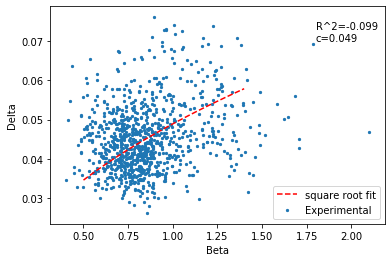

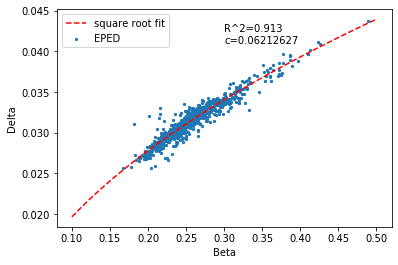

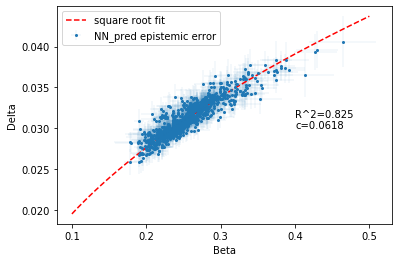

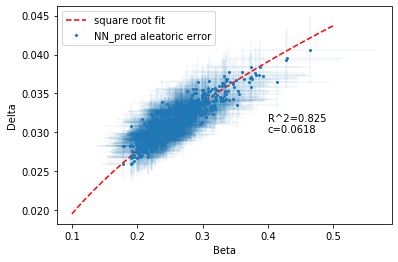

In [125]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
def f(x,a):
    return a*np.sqrt(x)
#EXP
beta=plasma0.Te_ped_exp.values*plasma0.ne_ped_exp.values/plasma0['Ip[MA]'].values**2
delta=plasma0.Delta_exp.values
dfbeta=pd.DataFrame({'delta_nn':delta.reshape(-1),'beta_nn':beta.reshape(-1)})
# dfbeta[dfbeta['beta_nn']>100]=np.nan
# dfbeta=dfbeta.dropna(axis=0)
popt_exp,pcov=curve_fit(f,dfbeta.beta_nn,dfbeta.delta_nn,maxfev=50000)
x=np.linspace(0.5,1.4,100)
plt.plot(x,f(x,popt_exp),'r--',label='square root fit')
plt.scatter(beta,delta,s=5,label='Experimental')
plt.ylabel('Delta')
plt.xlabel('Beta')
r2_exp=r2_score(dfbeta.delta_nn, f(dfbeta.beta_nn,popt_exp))
plt.annotate('R^2='+str(np.round(r2_exp,3))+'\n'+'c='+str(np.round(popt_exp[0],3)),xy=[1.8,0.07])
plt.legend()
plt.show()

#EPED
beta_eped=beta_fun()#plasma.Te_ped_EPED.values*plasma.ne_ped_exp.values/plasma['Ip[MA]'].values**2
delta_eped=plasma0.Delta_EPED.values
dfbeta=pd.DataFrame({'delta_nn':delta_eped.reshape(-1),'beta_nn':beta_eped.reshape(-1)})
dfbeta[dfbeta['beta_nn']>100]=np.nan
dfbeta=dfbeta.dropna(axis=0)
popt_eped,pcov=curve_fit(f,dfbeta.beta_nn,dfbeta.delta_nn,maxfev=50000)
x=np.linspace(0.1,0.5,100)
plt.plot(x,f(x,popt_eped),'r--',label='square root fit')
plt.scatter(beta_eped,delta_eped,s=5,label='EPED')
plt.ylabel('Delta')
plt.xlabel('Beta')
r2_eped=r2_score(dfbeta.delta_nn, f(dfbeta.beta_nn,popt_eped))
plt.annotate('R^2='+str(np.round(r2_eped,3))+'\n'+'c='+str(np.round(popt_eped[0],8)),xy=[0.3,0.041])
plt.legend()
plt.show()
dfbeta_eped=dfbeta

#NN Epistemic
beta_nn=beta_fun((mean_dist.mean().numpy()*myscaler(plasma0.Te_ped_EPED)[2])+myscaler(plasma0.Te_ped_EPED)[1])#(mean_dist.mean().numpy().reshape(-1)*plasma.ne_ped_exp.values)/(plasma['Ip[MA]'].values)**2
delta_nn=(mean_dist2.mean().numpy()*myscaler(plasma0.Delta_EPED)[2])+myscaler(plasma0.Delta_EPED)[1]
dfbeta=pd.DataFrame({'delta_nn':delta_nn.reshape(-1),'beta_nn':beta_nn.reshape(-1),
    'epi_beta':beta_error(mean_dist.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_EPED)[2]),
    'epi_delta':mean_dist2.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_EPED)[2]})
dfbeta[dfbeta['beta_nn']>100]=np.nan
dfbeta=dfbeta.dropna(axis=0)
plt.errorbar(dfbeta.beta_nn,dfbeta.delta_nn,yerr=dfbeta.epi_delta,xerr=dfbeta.epi_beta,label='NN_pred epistemic error',fmt='o',markersize=2,elinewidth=0.09)

popt_nn,pcov=curve_fit(f,dfbeta.beta_nn,dfbeta.delta_nn,sigma=dfbeta.epi_delta,maxfev=50000)

x=np.linspace(0.1,0.5,100)
plt.plot(x,f(x,popt_nn),'r--',label='square root fit')
r2_nn=r2_score(dfbeta.delta_nn, f(dfbeta.beta_nn,popt_nn))
plt.annotate('R^2='+str(np.round(r2_nn,3))+'\n'+'c='+str(np.round(popt_nn[0],5)),xy=[0.4,0.030])
plt.ylabel('Delta')
plt.xlabel('Beta')
plt.legend()
plt.show()
dfbeta_epi=dfbeta

#NN Aleatoric
beta_nn=beta_fun((mean_dist.mean().numpy()*myscaler(plasma0.Te_ped_EPED)[2])+myscaler(plasma0.Te_ped_EPED)[1])#(mean_dist.mean().numpy().reshape(-1)*plasma.ne_ped_exp.values)/(plasma['Ip[MA]'].values)**2
delta_nn=(mean_dist2.mean().numpy()*myscaler(plasma0.Delta_EPED)[2])+myscaler(plasma0.Delta_EPED)[1]
dfbeta=pd.DataFrame({'delta_nn':delta_nn.reshape(-1),'beta_nn':beta_nn.reshape(-1),
    'epi_beta':beta_error(ndim_out_dist.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_EPED)[2]),
    'epi_delta':ndim_out_dist2.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_EPED)[2]})
dfbeta[dfbeta['beta_nn']>100]=np.nan
dfbeta=dfbeta.dropna(axis=0)
plt.errorbar(dfbeta.beta_nn,dfbeta.delta_nn,yerr=dfbeta.epi_delta,xerr=dfbeta.epi_beta,label='NN_pred aleatoric error',fmt='o',markersize=2,elinewidth=0.09)

popt_nn_alea,pcov=curve_fit(f,dfbeta.beta_nn,dfbeta.delta_nn,sigma=dfbeta_epi.epi_delta,maxfev=50000)

x=np.linspace(0.1,0.5,100)
plt.plot(x,f(x,popt_nn),'r--',label='square root fit')
r2_nn=r2_score(dfbeta.delta_nn, f(dfbeta.beta_nn,popt_nn))
plt.annotate('R^2='+str(np.round(r2_nn,3))+'\n'+'c='+str(np.round(popt_nn_alea[0],5)),xy=[0.4,0.030])
plt.ylabel('Delta')
plt.xlabel('Beta')
plt.legend()
plt.show()

In [126]:
selected_dataset.columns

Index(['Ip[MA]', 'Bt[T]', 'Triang.', 'epsilon', 'kappa', 'beta_n_exp',
       'ne_ped_exp', 'Te_ped_EPED', 'Delta_EPED', 'Sigma_Te_ped',
       'Sigma_Delta'],
      dtype='object')

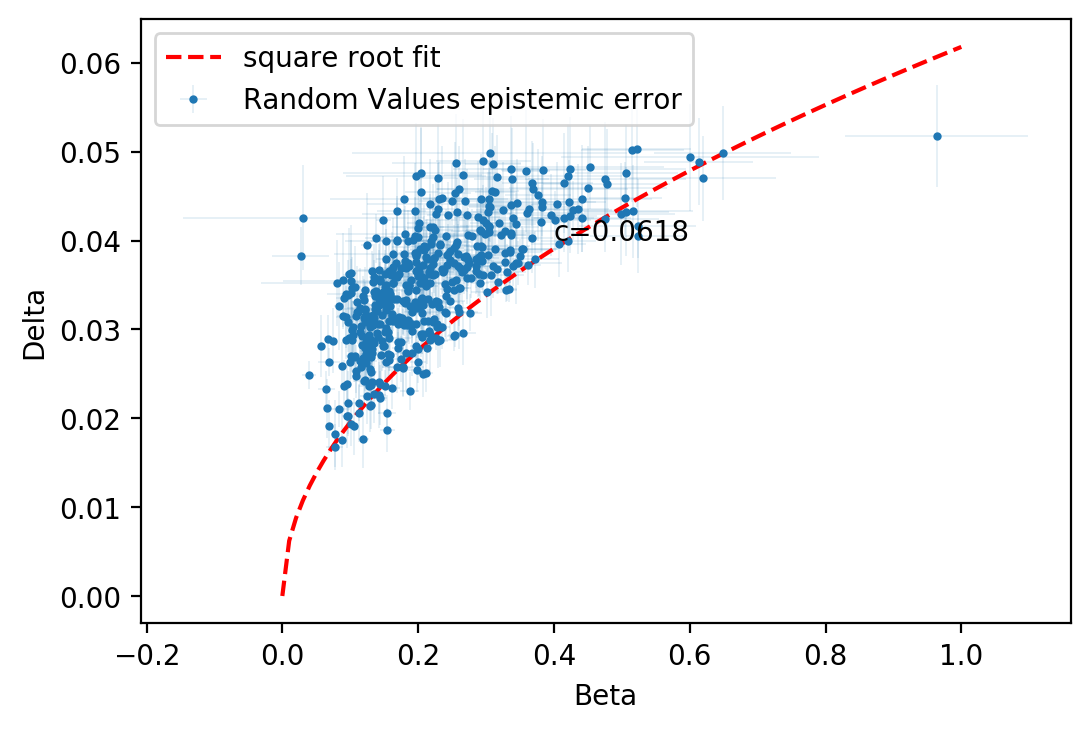

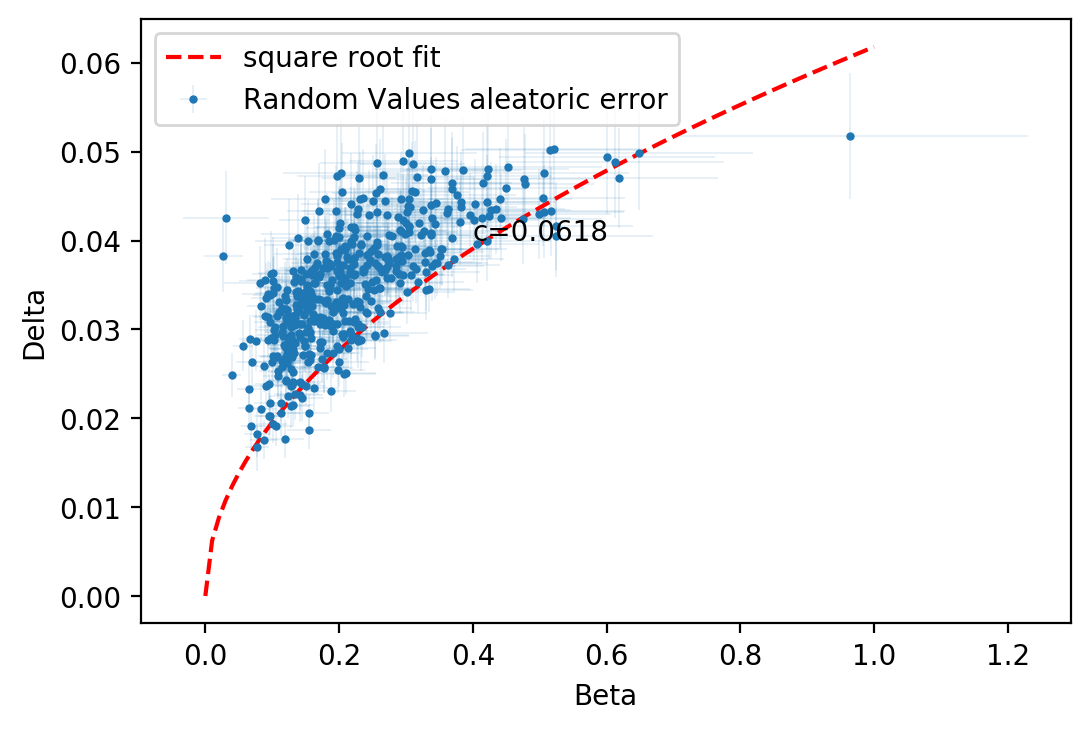

In [127]:
def beta_fun(Te_ped=plasma0.Te_ped_EPED.values,ne_ped=plasma0.ne_ped_exp.values,triang=plasma0['Triang.'].values,rminor=plasma0['rminor[m]'].values,kappa=plasma0.kappa.values,ip=plasma0['Ip[MA]'].values,zeff=plasma0.Zeff_h.values):
    mu0=4*np.pi*10**(-7)
    theta = np.linspace(0, 2*np.pi, 361).reshape(1,-1)
    dx = np.sin(theta + np.arcsin(triang.reshape(-1,1)) * np.sin(theta)) * (1 + np.arcsin(triang.reshape(-1,1)) * np.cos(theta))
    dy = kappa.reshape(-1,1) * np.cos(theta)
    Lp = rminor.reshape(-1,1) * np.trapz(np.sqrt(dx**2 + dy**2), theta).reshape(-1,1)
    Bp2 = (ip.reshape(-1,1)*1e6 * mu0 / Lp)**2
    pe_ped = ne_ped.reshape(-1,1)*1e19 * Te_ped.reshape(-1,1)*1.6e-16
    Zimp = 4
    pi_ped = pe_ped * (Zimp - zeff.reshape(-1,1)) / (Zimp - 1)
    beta = (pe_ped + pi_ped) * (2 * mu0) / Bp2
    return beta
def beta_error(Te_ped_error,ne_ped=plasma0.ne_ped_exp.values,triang=plasma0['Triang.'].values,rminor=plasma0['rminor[m]'].values,kappa=plasma0.kappa.values,ip=plasma0['Ip[MA]'].values,zeff=plasma0.Zeff_h.values):
    mu0=4*np.pi*10**(-7)
    theta = np.linspace(0, 2*np.pi, 361).reshape(1,-1)
    dx = np.sin(theta + np.arcsin(triang.reshape(-1,1)) * np.sin(theta)) * (1 + np.arcsin(triang.reshape(-1,1)) * np.cos(theta))
    dy = kappa.reshape(-1,1) * np.cos(theta)
    Lp = rminor.reshape(-1,1) * np.trapz(np.sqrt(dx**2 + dy**2), theta).reshape(-1,1)
    Bp2 = (ip.reshape(-1,1)*1e6 * mu0 / Lp)**2
    dpe=ne_ped.reshape(-1)*1e19*Te_ped_error*1.6e-16
    
    Zimp=4
    dpi=dpe*(Zimp-zeff.reshape(-1))/(Zimp-1)
    
    dbeta=(dpe+dpi)*2*mu0/Bp2.reshape(-1)
    return dbeta.reshape(-1)
size=500
def unif_sample(var,size=size):
    return np.random.uniform(low=0.5*plasma[var].values.min(), high=1.5*plasma[var].values.max(),size=size).reshape(-1)
selected_dataset['rminor[m]']=plasma0['rminor[m]']
selected_dataset['Zeff_h']=plasma0['Zeff_h']
selected_dataset=selected_dataset.loc[:,['Ip[MA]', 'Bt[T]', 'Triang.', 'epsilon', 'kappa', 'beta_n_exp',
       'ne_ped_exp', 'Te_ped_EPED', 'Delta_EPED', 'rminor[m]', 'Zeff_h']]
cov_plasma=np.cov(selected_dataset.values.T)+0*np.cov(selected_dataset.values.T)
mean_plasma=selected_dataset.mean().values
# mean_plasma[0]=mean_plasma[0]*0.7
# mean_plasma[-5]=mean_plasma[-5]*1.5
Bt_rn=unif_sample('Bt[T]')
Ip_rn=unif_sample('Ip[MA]')
Trian_rn=unif_sample('Triang.')
eps_rn=unif_sample('epsilon')
kap_rn=unif_sample('kappa')
beta_rn=unif_sample('beta_n_exp')
ne_ped_rn=unif_sample('ne_ped_exp')
zeff_rn=unif_sample('Zeff_h')
rmin_rn=unif_sample('rminor[m]')
def un_norm(a,var):
    return a*myscaler(plasma0[var])[2]+myscaler(plasma0[var])[1]
Bt_r=un_norm(Bt_rn,'Bt[T]')
Ip_r=un_norm(Ip_rn,'Ip[MA]')
Trian_r=un_norm(Trian_rn,'Triang.')
eps_r=un_norm(eps_rn,'epsilon')
kap_r=un_norm(kap_rn,'kappa')
beta_r=un_norm(beta_rn,'beta_n_exp')
ne_ped_r=un_norm(ne_ped_rn,'ne_ped_exp')
zeff_r=un_norm(zeff_rn,'Zeff_h')
rmin_r=un_norm(rmin_rn,'rminor[m]')
sample=np.random.multivariate_normal(mean_plasma,cov_plasma,size)
sample_norm=tf.constant(myscaler(sample)[0],dtype=tf.float32)
# sample_norm
alea_dist_rand,mean_dist_rand,alea_dist_rand2,mean_dist_rand2=model([tf.constant(Ip_rn,dtype=tf.float32),
    tf.constant(Bt_rn,dtype=tf.float32),tf.constant(Trian_rn,dtype=tf.float32),
    tf.constant(eps_rn,dtype=tf.float32),tf.constant(kap_rn,dtype=tf.float32),
    tf.constant(beta_rn,dtype=tf.float32),tf.constant(ne_ped_rn,dtype=tf.float32)])

# alea_dist_rand,mean_dist_rand,alea_dist_rand2,mean_dist_rand2=model([sample_norm[:,0],
#     sample_norm[:,1],sample_norm[:,2],sample_norm[:,3],
#     sample_norm[:,4],sample_norm[:,5],sample_norm[:,6]])

# beta_nn=beta_fun(mean_dist_rand.mean().numpy()*myscaler(plasma0.Te_ped_EPED)[2]+myscaler(plasma0.Te_ped_EPED)[1],ip=Ip_r,ne_ped=sample[:,6],triang=sample[:,2],rminor=sample[:,-2],kappa=sample[:,4],zeff=sample[:,-1])
# delta_nn=mean_dist_rand2.mean().numpy()*myscaler(plasma0.Delta_EPED)[2]+myscaler(plasma0.Delta_EPED)[1]
# dfbeta_random=pd.DataFrame({'delta_nn':delta_nn.reshape(-1),'beta_nn':beta_nn.reshape(-1),
#     'epi_beta':beta_error(mean_dist_rand.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_EPED)[2],ip=sample[:,0],ne_ped=sample[:,6],triang=sample[:,2],rminor=sample[:,-2],kappa=sample[:,4],zeff=sample[:,-1]),
#     'epi_delta':mean_dist_rand2.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_EPED)[2],
#     'alea_beta':beta_error(alea_dist_rand.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_EPED)[2],ip=sample[:,0],ne_ped=sample[:,6],triang=sample[:,2],rminor=sample[:,-2],kappa=sample[:,4],zeff=sample[:,-1]),
#     'alea_delta':alea_dist_rand2.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_EPED)[2]})

beta_nn=beta_fun(mean_dist_rand.mean().numpy()*myscaler(plasma0.Te_ped_EPED)[2]+myscaler(plasma0.Te_ped_EPED)[1],ip=Ip_r,ne_ped=ne_ped_r,triang=Trian_r,rminor=rmin_r,kappa=kap_r,zeff=zeff_r)
delta_nn=mean_dist_rand2.mean().numpy()*myscaler(plasma0.Delta_EPED)[2]+myscaler(plasma0.Delta_EPED)[1]
dfbeta_random=pd.DataFrame({'delta_nn':delta_nn.reshape(-1),'beta_nn':beta_nn.reshape(-1),
    'epi_beta':beta_error(mean_dist_rand.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_EPED)[2],ip=Ip_r,ne_ped=ne_ped_r,triang=Trian_r,rminor=rmin_r,kappa=kap_r,zeff=zeff_r),
    'epi_delta':mean_dist_rand2.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_EPED)[2],
    'alea_beta':beta_error(alea_dist_rand.stddev().numpy().reshape(-1)*myscaler(plasma0.Te_ped_EPED)[2],ip=Ip_r,ne_ped=ne_ped_r,triang=Trian_r,rminor=rmin_r,kappa=kap_r,zeff=zeff_r),
    'alea_delta':alea_dist_rand2.stddev().numpy().reshape(-1)*myscaler(plasma0.Delta_EPED)[2]})
dfbeta_random[dfbeta_random['beta_nn']>100]=np.nan
dfbeta_random=dfbeta_random.dropna(axis=0)
dfbeta_random=dfbeta_random.loc[(dfbeta_random['beta_nn']>0.),:]
plt.figure(dpi=200)
plt.errorbar(dfbeta_random.beta_nn,dfbeta_random.delta_nn,yerr=dfbeta_random.epi_delta,xerr=dfbeta_random.epi_beta,label='Random Values epistemic error',fmt='o',markersize=2,elinewidth=0.08)
x=np.linspace(0,1,100)
plt.plot(x,f(x,popt_nn),'r--',label='square root fit')
plt.annotate('c='+str(np.round(popt_nn[0],4)),xy=[0.4,0.04])
plt.ylabel('Delta')
plt.xlabel('Beta')
plt.legend()
plt.show()
plt.figure(dpi=200)
plt.errorbar(dfbeta_random.beta_nn,dfbeta_random.delta_nn,yerr=dfbeta_random.alea_delta,xerr=dfbeta_random.alea_beta,label='Random Values aleatoric error',fmt='o',markersize=2,elinewidth=0.08)
# plt.xlim(-0.25,2)
# plt.ylim(-0.075,0.1)
# popt_nn,pcov=curve_fit(f,dfbeta_random.beta_nn,dfbeta_random.delta_nn,sigma=dfbeta_random.epi_delta,maxfev=50000)

x=np.linspace(0,1,100)
plt.plot(x,f(x,popt_nn),'r--',label='square root fit')
# r2_nn=r2_score(dfbeta_random.delta_nn, f(dfbeta_random.beta_nn,popt_nn))
plt.annotate('c='+str(np.round(popt_nn[0],4)),xy=[0.4,0.04])
plt.ylabel('Delta')
plt.xlabel('Beta')
plt.legend()
plt.show()
def min_dist(beta,delta):
    x=np.linspace(0,2,100)
    y=f(x,popt_nn)
    d=np.min(np.sqrt((x-beta)**2+100*(y-delta)**2))
    return d
dfbeta.beta_nn.mean()
def min_dist_data(beta,delta):
    x=dfbeta_eped.beta_nn.mean()
    y=dfbeta_eped.delta_nn.mean()
    # x=dfbeta.beta_nn.values.reshape(-1)
    # y=dfbeta.delta_nn.values.reshape(-1)
    d=np.sqrt((x-beta)**2+100*(y-delta)**2)
    return d
dfbeta_random['dist_curve']=np.vectorize(min_dist)(dfbeta_random.loc[:,'beta_nn'],dfbeta_random.loc[:,'delta_nn'])
dfbeta_random['dist_data']=min_dist_data(dfbeta_random.loc[:,'beta_nn'],dfbeta_random.loc[:,'delta_nn'])
dfbeta_random['dist']=dfbeta_random['dist_data']+dfbeta_random['dist_curve']


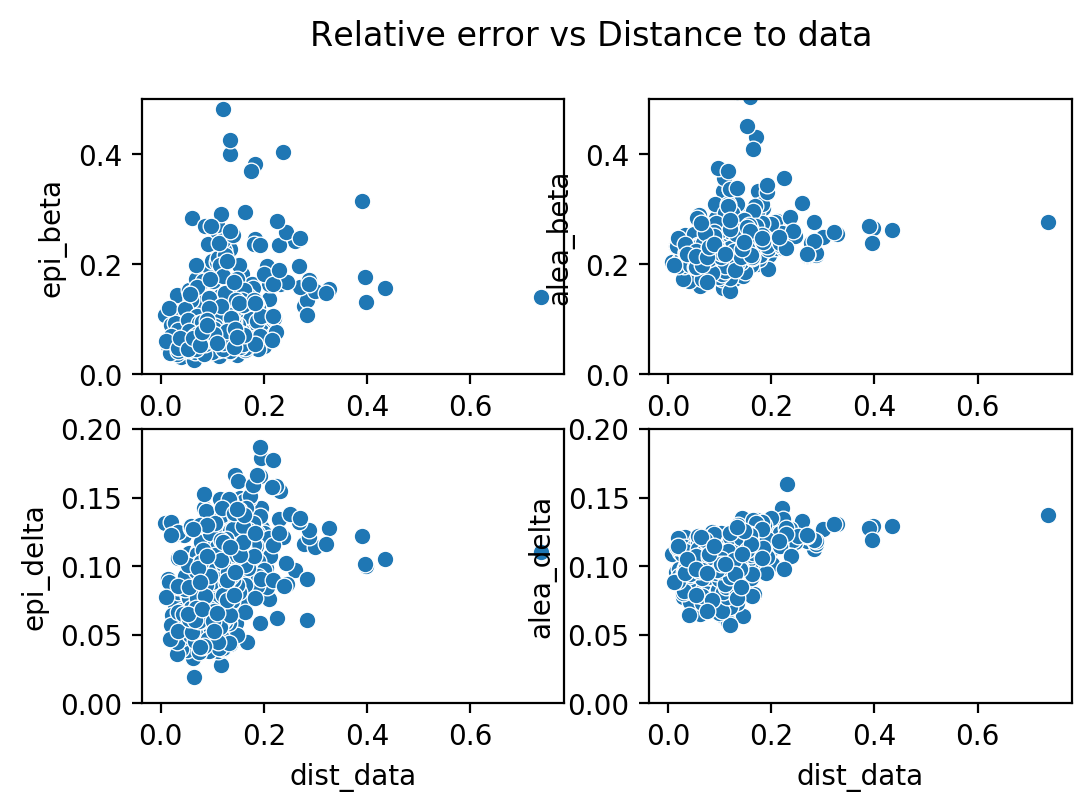

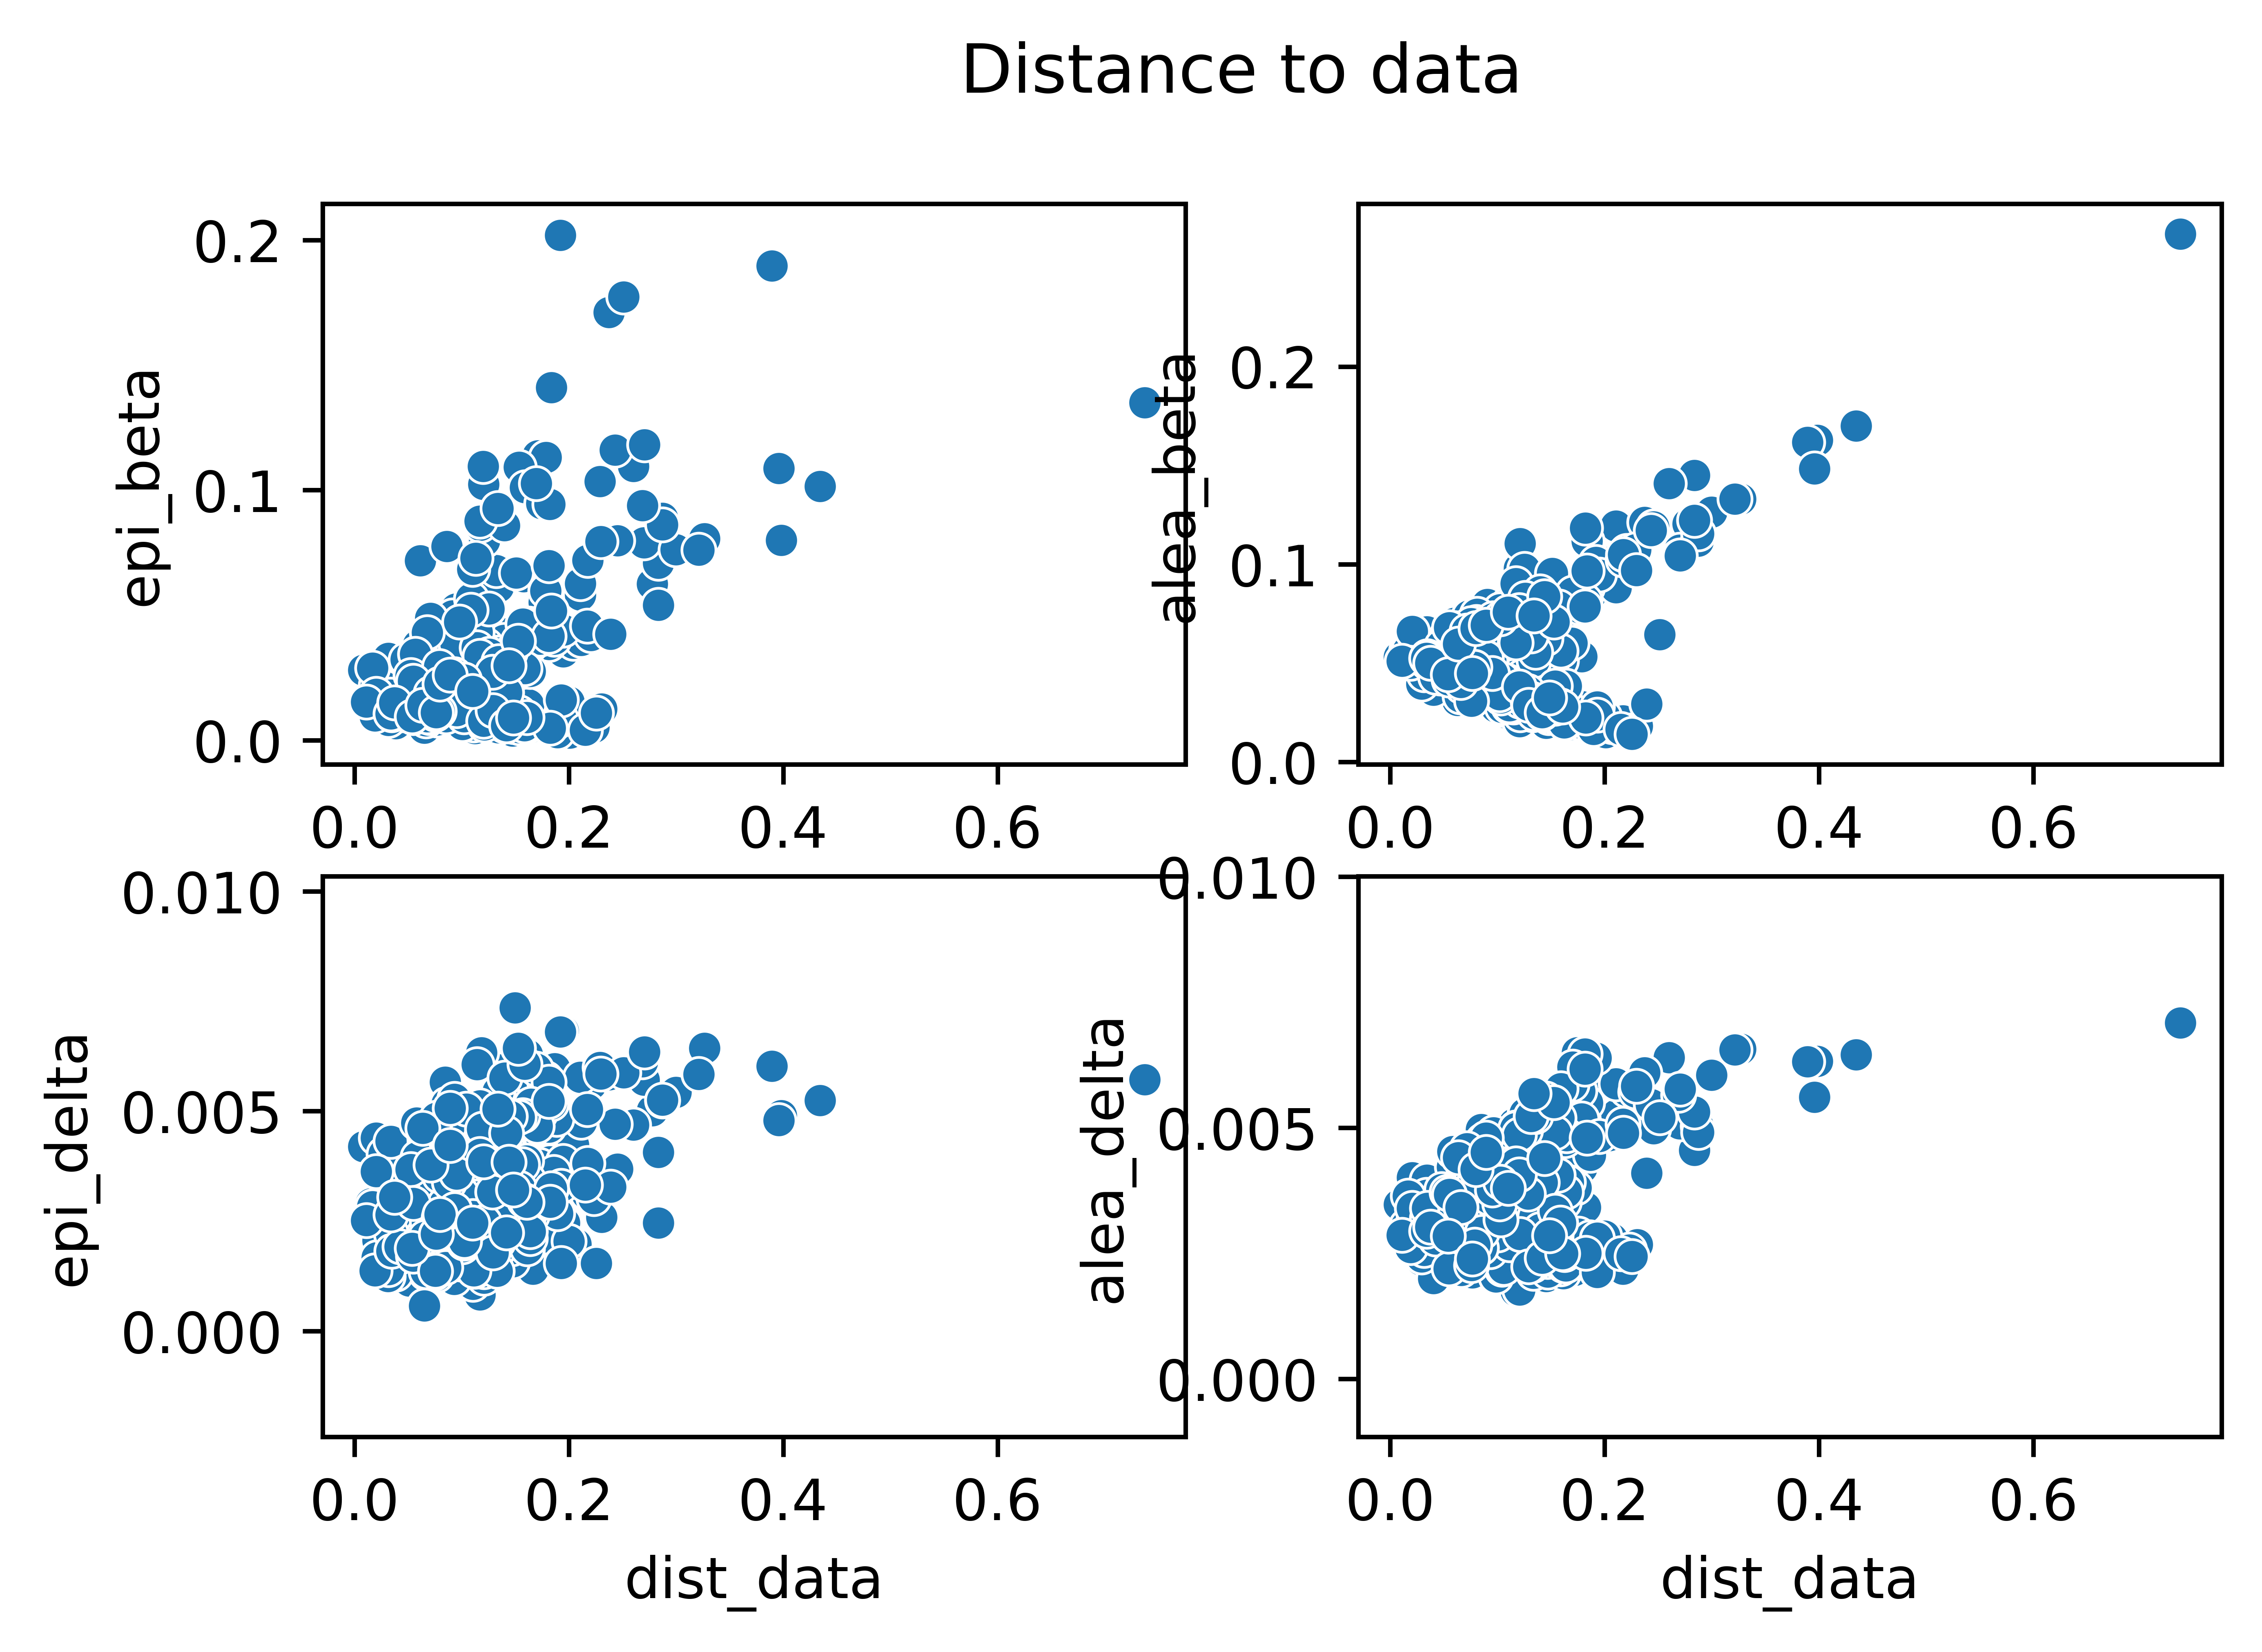

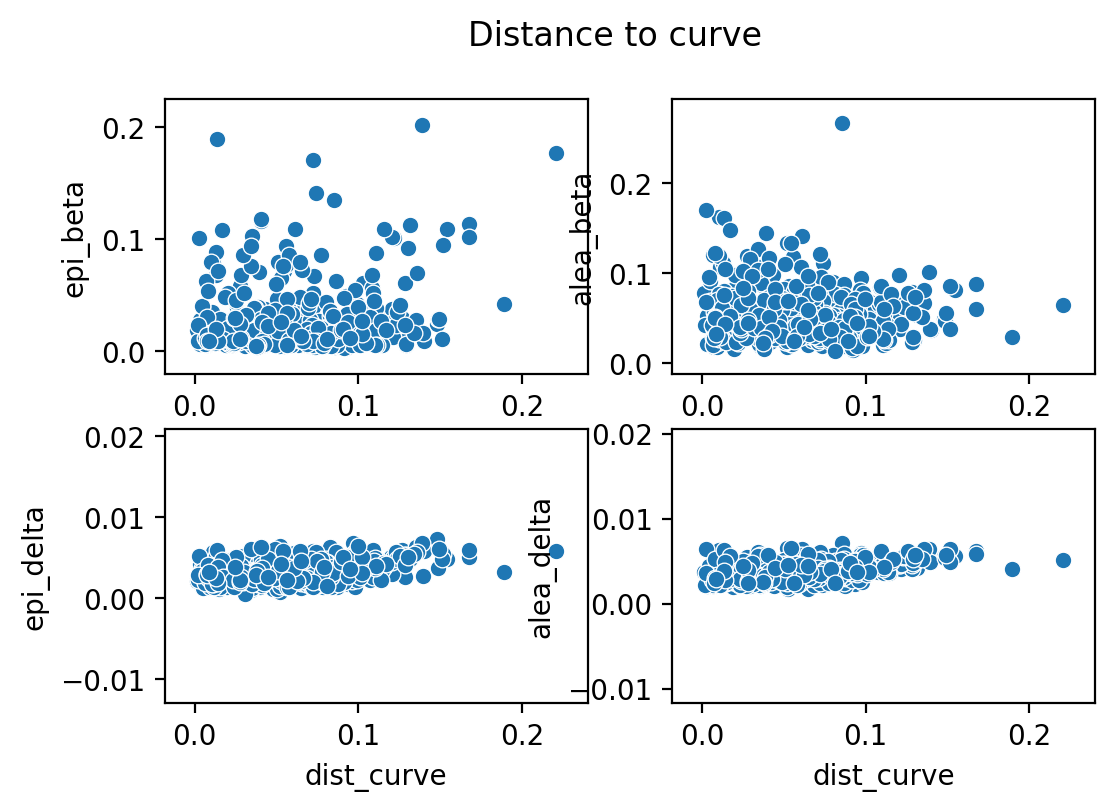

In [128]:
# dfbeta_random_random[['epi_beta','dist']]
fig,ax=plt.subplots(2,2,dpi=200)
plt.suptitle('Relative error vs Distance to data')

sns.scatterplot(data=dfbeta_random,x=dfbeta_random['dist_data'],y=dfbeta_random['epi_beta']/dfbeta_random['beta_nn'],ax=ax[0,0])
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_ylabel('epi_beta')
# sns.scatterplot(data=data_weird,x='dist_data',y='epi_beta',color='r',label='weird points',ax=ax[0,0])
sns.scatterplot(data=dfbeta_random,x=dfbeta_random['dist_data'],y=dfbeta_random['epi_delta']/dfbeta_random['delta_nn'],ax=ax[1,0])
# ax[1,0].ylabel('epi_delta')
ax[1,0].set_ylim(0,0.2)
ax[1,0].set_ylabel('epi_delta')
# sns.scatterplot(data=data_weird,x='dist_data',y='epi_delta',color='r',label='weird points',ax=ax[1,0])
sns.scatterplot(data=dfbeta_random,x=dfbeta_random['dist_data'],y=dfbeta_random['alea_beta']/dfbeta_random['beta_nn'],ax=ax[0,1])
ax[0,1].set_ylim(0,0.5)
ax[0,1].set_ylabel('alea_beta')
# sns.scatterplot(data=data_weird,x='dist_data',y='alea_beta',color='r',label='weird points',ax=ax[0,1])
sns.scatterplot(data=dfbeta_random,x=dfbeta_random['dist_data'],y=dfbeta_random['alea_delta']/dfbeta_random['delta_nn'],ax=ax[1,1])
# sns.scatterplot(data=data_weird,x='dist_data',y='alea_delta',color='r',label='weird points',ax=ax[1,1])
ax[1,1].set_ylim(0,0.2)
ax[1,1].set_ylabel('alea_delta')
plt.show()

fig,ax=plt.subplots(2,2,dpi=1000)
plt.suptitle('Distance to data')
sns.scatterplot(data=dfbeta_random,x='dist_data',y='epi_beta',ax=ax[0,0])

# sns.scatterplot(data=data_weird,x='dist_data',y='epi_beta',color='r',label='weird points',ax=ax[0,0])
sns.scatterplot(data=dfbeta_random,x='dist_data',y='epi_delta',ax=ax[1,0])

# sns.scatterplot(data=data_weird,x='dist_data',y='epi_delta',color='r',label='weird points',ax=ax[1,0])
sns.scatterplot(data=dfbeta_random,x='dist_data',y='alea_beta',ax=ax[0,1])

# sns.scatterplot(data=data_weird,x='dist_data',y='alea_beta',color='r',label='weird points',ax=ax[0,1])
sns.scatterplot(data=dfbeta_random,x='dist_data',y='alea_delta',ax=ax[1,1])
# sns.scatterplot(data=data_weird,x='dist_data',y='alea_delta',color='r',label='weird points',ax=ax[1,1])

plt.show()

fig,ax=plt.subplots(2,2,dpi=200)
plt.suptitle('Distance to curve')

sns.scatterplot(data=dfbeta_random,x='dist_curve',y='epi_beta',ax=ax[0,0])
sns.scatterplot(data=dfbeta_random,x='dist_curve',y='epi_delta',ax=ax[1,0])
sns.scatterplot(data=dfbeta_random,x='dist_curve',y='alea_beta',ax=ax[0,1])
sns.scatterplot(data=dfbeta_random,x='dist_curve',y='alea_delta',ax=ax[1,1])

# sns.scatterplot(data=data_weird,x='dist_curve',y='epi_beta',color='r',label='weird points',ax=ax[0,0])

# sns.scatterplot(data=data_weird,x='dist_curve',y='epi_delta',color='r',label='weird points',ax=ax[1,0])

# sns.scatterplot(data=data_weird,x='dist_curve',y='alea_beta',color='r',label='weird points',ax=ax[0,1])

# sns.scatterplot(data=data_weird,x='dist_curve',y='alea_delta',color='r',label='weird points',ax=ax[1,1])
plt.show()


Text(0, 0.5, 'alea_delta')

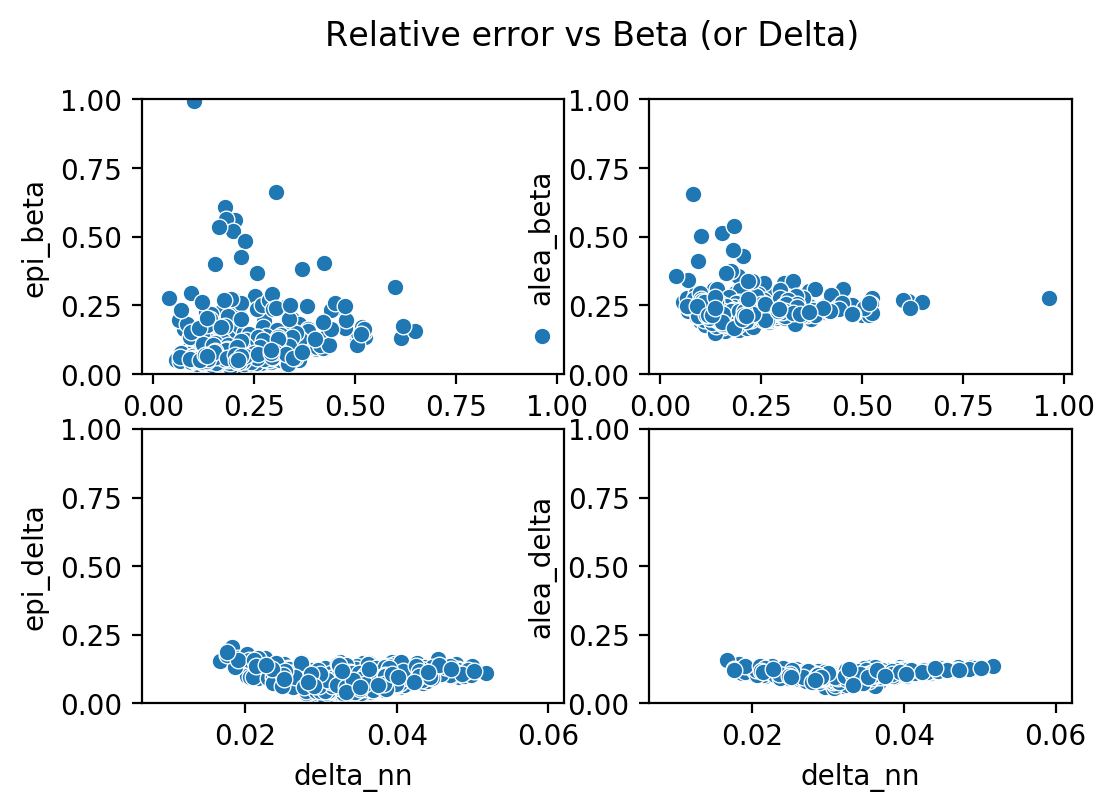

In [129]:
fig,ax=plt.subplots(2,2,dpi=200)
plt.suptitle('Relative error vs Beta (or Delta)')

sns.scatterplot(data=dfbeta_random,x=dfbeta_random['beta_nn'],y=dfbeta_random['epi_beta']/dfbeta_random['beta_nn'],ax=ax[0,0])
ax[0,0].set_ylim(0,1)
ax[0,0].set_ylabel('epi_beta')
# sns.scatterplot(data=data_weird,x='dist_data',y='epi_beta',color='r',label='weird points',ax=ax[0,0])
sns.scatterplot(data=dfbeta_random,x=dfbeta_random['delta_nn'],y=dfbeta_random['epi_delta']/dfbeta_random['delta_nn'],ax=ax[1,0])
# ax[1,0].ylabel('epi_delta')
ax[1,0].set_ylim(0,1)
ax[1,0].set_ylabel('epi_delta')
# sns.scatterplot(data=data_weird,x='dist_data',y='epi_delta',color='r',label='weird points',ax=ax[1,0])
sns.scatterplot(data=dfbeta_random,x=dfbeta_random['beta_nn'],y=dfbeta_random['alea_beta']/dfbeta_random['beta_nn'],ax=ax[0,1])
ax[0,1].set_ylim(0,1)
ax[0,1].set_ylabel('alea_beta')
# sns.scatterplot(data=data_weird,x='dist_data',y='alea_beta',color='r',label='weird points',ax=ax[0,1])
sns.scatterplot(data=dfbeta_random,x=dfbeta_random['delta_nn'],y=dfbeta_random['alea_delta']/dfbeta_random['delta_nn'],ax=ax[1,1])
# sns.scatterplot(data=data_weird,x='dist_data',y='alea_delta',color='r',label='weird points',ax=ax[1,1])
ax[1,1].set_ylim(0,1)
ax[1,1].set_ylabel('alea_delta')
# plt.show()
# plt.scatter(dfbeta_random.beta_nn.values,dfbeta_random.alea_beta.values/dfbeta_random.beta_nn.values)
# plt.ylim(0,0.5)

# plt.show()
# plt.scatter(dfbeta_random.beta_nn.values,dfbeta_random.epi_beta.values/dfbeta_random.beta_nn.values)
# plt.ylim(0,0.5)

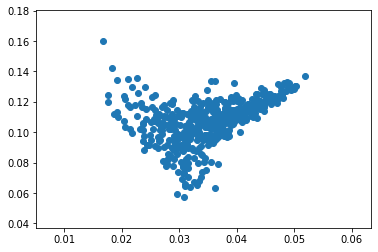

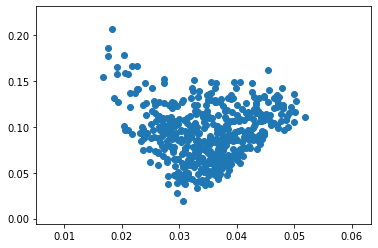

In [130]:
plt.scatter(dfbeta_random.delta_nn.values,dfbeta_random.alea_delta.values/dfbeta_random.delta_nn.values)

plt.show()
plt.scatter(dfbeta_random.delta_nn.values,dfbeta_random.epi_delta.values/dfbeta_random.delta_nn.values)


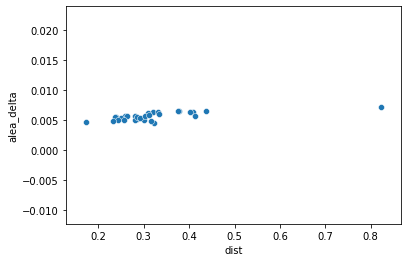

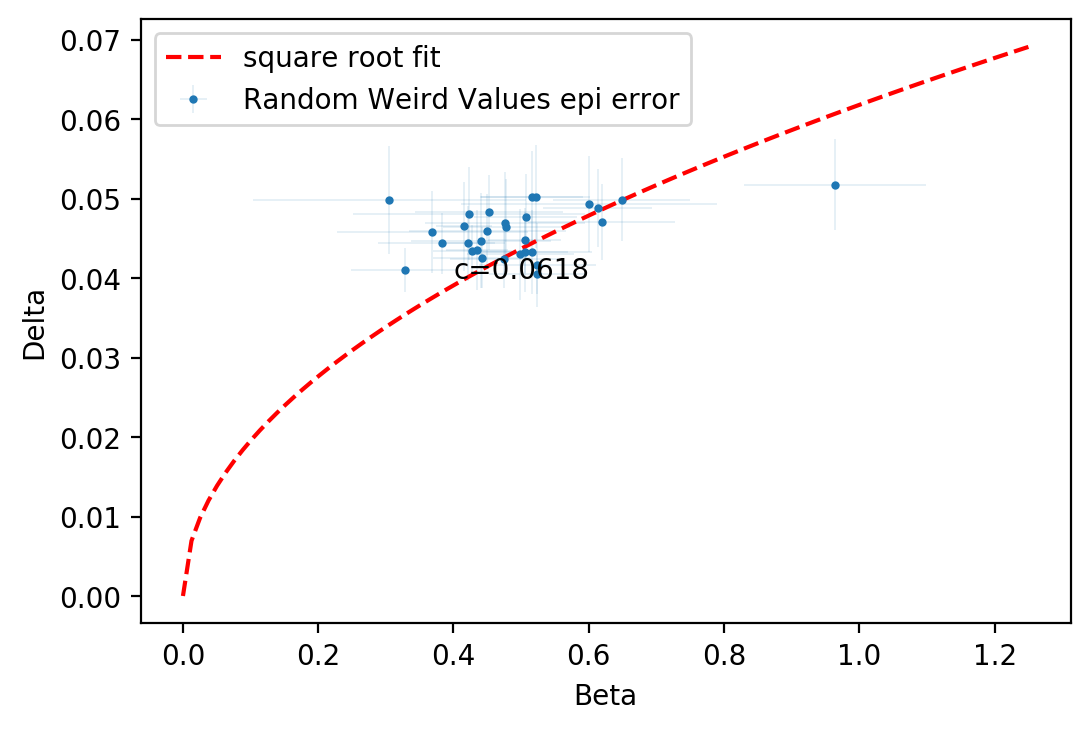

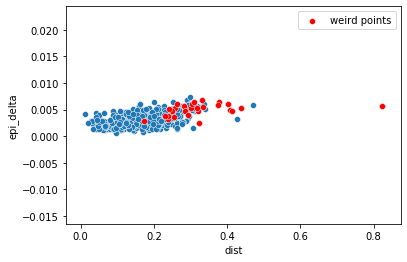

In [131]:

data_weird=dfbeta_random.loc[(dfbeta_random['alea_beta']>0.1),:]
sns.scatterplot(data=data_weird,x='dist',y='alea_delta')
plt.show()
plt.figure(dpi=200)
plt.errorbar(data_weird.beta_nn.values,data_weird.delta_nn.values,yerr=data_weird.epi_delta.values,xerr=data_weird.epi_beta.values,label='Random Weird Values epi error',fmt='o',markersize=2,elinewidth=0.08)

x=np.linspace(0,1.25,100)
plt.plot(x,f(x,popt_nn),'r--',label='square root fit')
plt.annotate('c='+str(np.round(popt_nn[0],4)),xy=[0.4,0.04])
plt.ylabel('Delta')
plt.xlabel('Beta')
plt.legend()
plt.show()
sns.scatterplot(data=dfbeta_random,x='dist',y='epi_delta')
sns.scatterplot(data=data_weird,x='dist',y='epi_delta',color='r',label='weird points')

In [132]:
ndim_out_dist, mean_dist,ndim_out_dist2,mean_dist2=model([tf.constant(Train['Ip[MA]'].values,dtype=tf.float32),tf.constant(Train['Bt[T]'].values,dtype=tf.float32),
    tf.constant(Train['Triang.'].values,dtype=tf.float32),
    tf.constant(Train['Rmag[M]'].values,dtype=tf.float32),tf.constant(Train['rminor[m]'].values,dtype=tf.float32),
    tf.constant(Train['kappa'].values,dtype=tf.float32),tf.constant(Train['beta_n_exp'].values,dtype=tf.float32),
    tf.constant(Train['ne_ped_exp'].values,dtype=tf.float32)])

KeyError: 'Rmag[M]'

In [ ]:
z_epi = mean_dist.stddev().numpy()
alea_uncertainty=ndim_out_dist[0].stddev().numpy()+ ndim_out_dist[1].stddev().numpy()+ndim_out_dist[2].stddev().numpy()+ndim_out_dist[3].stddev().numpy()+ndim_out_dist[4].stddev().numpy()+ndim_out_dist[5].stddev().numpy()+ndim_out_dist[6].stddev().numpy()+ndim_out_dist[7].stddev().numpy()

In [ ]:
B=np.linspace(0,4,1000)
ndim_out_dist_B, mean_dist_B,ndim_out_dist2_B, mean_dist2_B=model([tf.constant(np.full(B.shape,1.5),dtype=tf.float32),tf.constant(B,dtype=tf.float32),
    tf.constant(np.full(B.shape,0.2),dtype=tf.float32),tf.constant(np.full(B.shape,3),dtype=tf.float32),
    tf.constant(np.full(B.shape,0.9),dtype=tf.float32),tf.constant(np.full(B.shape,1.6),dtype=tf.float32),
    tf.constant(np.full(B.shape,1.3),dtype=tf.float32),tf.constant(np.full(B.shape,5),dtype=tf.float32)])
z_epi_B = mean_dist_B.stddev().numpy()
# alea_uncertainty_B = np.add(ndim_out_dist_B[0].stddev().numpy(), ndim_out_dist_B[1].stddev().numpy())
alea_uncertainty_B=ndim_out_dist_B.stddev().numpy().sum(axis=0)
def plotbands(B,mean_dist_B,alea_uncertainty_B,z_epi_B,real=plasma['Te_ped_EPED'],plasma=plasma):
    df=pd.DataFrame({'x':B, 'mean':mean_dist_B.mean().numpy()[:,0], 'alea':alea_uncertainty_B[:,0],'epi':z_epi_B[:,0]}).sort_values(by='x')
    x_1=plasma['Bt[T]'].values
    df_1=pd.DataFrame({'x':x_1,'Te':real})
    error = 0.5*df.alea.values
    error2=0.5*df.epi.values
    lower = df['mean'].values - error
    upper = df['mean'].values + error
    lower2 = df['mean'].values - error2
    upper2 = df['mean'].values + error2
    fig, ax = plt.subplots(figsize=(9,5),dpi=400)

    ax.scatter(df.x, df['mean'], label=' mean',s=1)
    ax.plot(df.x, lower, color='tab:blue', alpha=0.1)
    ax.plot(df.x, upper, color='tab:blue', alpha=0.1)
    ax.scatter(df_1.x,df_1.Te,color='g',s=3,alpha=0.4,label='Real')
    # ax.plot(np.array([0,1.4]),np.array([0,1.4]))
    ax.fill_between(df.x, lower, upper,color='r', alpha=0.2,label='Aleatoric')
    ax.fill_between(df.x, lower2, upper2,color='b', alpha=0.2,label='Epistemic')

    ax.set_xlabel('Bt[T]')
    ax.set_ylabel('TePED predicted')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('weight epi 0.05, weight alea 0.05, I=1.5 ')
    # plt.ylim(-2,2)
    plt.legend()
    # plt.savefig('../figures/B_vs_Te_epi0.05_alea0.05.jpg')
    plt.show()
plotbands(B,mean_dist_B,alea_uncertainty_B,z_epi_B,plasma=plasma)
z_epi2_B = mean_dist2_B.stddev().numpy()
# alea_uncertainty_B = np.add(ndim_out_dist_B[0].stddev().numpy(), ndim_out_dist_B[1].stddev().numpy())
alea_uncertainty2_B=ndim_out_dist2_B.stddev().numpy().sum(axis=0)
plotbands(B,mean_dist2_B,alea_uncertainty2_B,z_epi2_B,real=plasma['Delta_EPED'],plasma=plasma)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

ValueError: x and y must be the same size

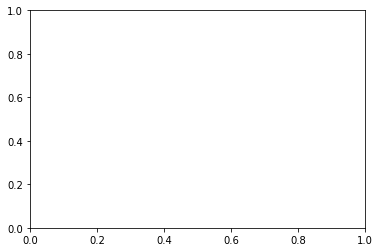

In [ ]:
plt.scatter(Train['Delta_EPED'],mean_dist2.mean(),s=5)
plt.plot(np.array([0.02,0.05]),np.array([0.02,0.05]))

ValueError: x and y must be the same size

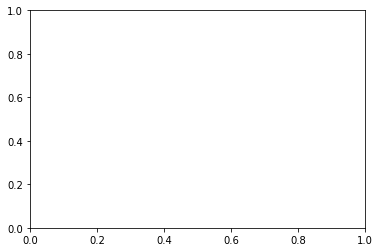

In [ ]:
plt.scatter(Train['Te_ped_EPED'],mean_dist.mean(),s=5)
plt.plot(np.array([0,1.4]),np.array([0,1.4]))